# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import os
import torch
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Subset, random_split
import torchvision.transforms as transforms #toTensor is the function you want to use
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from PIL import Image

In [2]:
#img_dir = "./project2-landmark/nd101-c2-landmarks-starter/landmark_project/landmark_images"
img_dir = "./landmark_images"

num_workers = 4 # Final
batch_size = 64 #  the number of data samples propagated through the network before the parameters are updated
n_outputs = 50
valid_size = 0.2 # percentage of training set to use as validation
n_epochs = 100 #the number times to iterate over the dataset

In [3]:
def verify_image(
            filename:str, 
            min_img_size_limit=(256,256),
        )->bool:
        """_summary_

        Args:
            filename (str): the image file to open
            check_image_variance (bool, optional): Set to True if you want to check if images
            has little to no variance in pixel values. So if the picture is all black verify_image would
            return False for that image. Defaults to False.

        Returns:
            bool: Returns true if the image checks all pass.
        """
        try:
            img = Image.open(filename) # open the image file
            img.verify() # verify that it is, in fact an image without loading the image.  It errors if there is a probelem.
            # check image has variance in data.
            
            width, height = img.size
            if min_img_size_limit is not None:
                if width < min_img_size_limit[0]:
                    return(False)
                elif height < min_img_size_limit[1]:
                    return(False)            
            img.close() #reload is necessary in my case
            return(True)
        except (IOError, SyntaxError) as e:
            print(f'Bad file: {filename}. Error: {e}') # print out the names of corrupt files
            return(False)

In [4]:
def get_transforms(n_outputs:int)->transforms.Compose:

    # Simplified transform - This works
    transform_img = transforms.Compose([
        transforms.Resize((256,256)), #resize all image down to 256 X 256 pixels
        transforms.ColorJitter(brightness=.1,hue=.1,contrast=.1,saturation=.1),
        transforms.RandomRotation(degrees=15), #randomly rotate between 15 and -15 degrees
        transforms.ToTensor(), # Convert image data to Tensor data type
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the data to have a mean of .5 and standard deviation .5)
        ])
    
    #one hot encoded tensor for label.  Assuming label is the numerical index of the label.
    #Reference: https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html#lambda-transforms
    #target_transform = Lambda(lambda y: torch.zeros(n_outputs, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    target_transform = None # Testing
    return(transform_img, target_transform)

In [5]:
# Create Split for newer python/pytorch version
def create_split(dataset, split)->list:
    result = random_split(dataset,split,generator=torch.Generator().manual_seed(42))
    return(result)

In [ ]:
# Create Split (older Python version)
def create_split_old(dataset, valid_size = .2):
    indices = list(range(0,len(dataset)))
    np.random.shuffle(indices)
    num_train = len(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # Following lines work, but need newer versions of pytorch
    #train_dataset = Subset(dataset, train_idx)
    #valid_dataset = Subset(dataset, valid_idx)

    train_sampler = SubsetRandomSampler(dataset, train_idx)
    valid_sampler = SubsetRandomSampler(dataset, valid_idx)
    return train_sampler, valid_sampler

In [9]:
def create_dataset(
        img_dir, 
        n_outputs, 
        batch_size:int,
        num_workers:int,
        shuffle:bool = True, 
        valid_size:float = 0.20
    )->dict:
    transform_img, target_transform = get_transforms(n_outputs)
    img_dataset = datasets.ImageFolder(os.path.join(img_dir,'train'),transform=transform_img, target_transform=target_transform, is_valid_file=verify_image)
    test_dataset = datasets.ImageFolder(os.path.join(img_dir,'test'),transform_img, target_transform, is_valid_file=verify_image)

    #train_sampler, valid_sampler = create_split_old(img_dataset)
    i_datasets = create_split(img_dataset, [.8,.2])

    train_loader = DataLoader(
        i_datasets[0], 
        batch_size=batch_size, 
        num_workers=num_workers, 
        shuffle=shuffle,
        #sampler=train_sampler,
    )
    valid_loader = DataLoader(
        i_datasets[1], 
        batch_size=batch_size, 
        num_workers=num_workers, 
        shuffle=shuffle,
        #sampler=valid_sampler,
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

    result = {
        "train":train_loader,
        "valid":valid_loader,
        "test":test_loader
    }
    return result

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_scratch = create_dataset(
    img_dir=img_dir, 
    n_outputs=n_outputs, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    valid_size=valid_size, 
    shuffle=False,
)

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

In terms of my transformation, I randomly reviewed the train data and based on what I saw, I decided to augmented my data by adding some variation through random rotations and color jitter. I thought color was important for identifying locations, based on the quality of the camera and/or time of day the picture was taken the color could vary. Through exploration of the photos, I also saw a few rotations and translations so I added the RandomRotation transformation. I chose these transformation so that my architecture could also learn from orientation changes and color changes. 

Additionally, the images were not all the same size, so I wanted to make sure I captured the same amount of information regardless of the original size of the photo. So I filtered any image that had dimensions less than 256 pixels, and then I resize all the photos to 256 x 256. I wanted the dimensions to squared and a base 2 exponential. Finally, I converted the image into a tensor and normalized that tensor so that my data was standardized across images.   

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Shape: (3, 256, 256) label: 17 class_label: 17.Changdeokgung
Transposed Shape: (256, 256, 3)


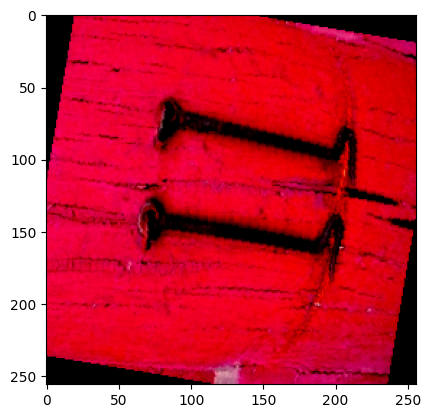

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

class_labels = list(loaders_scratch['train'].dataset.dataset.class_to_idx.keys())
train_images, train_labels = next(iter(loaders_scratch['train'])) # get the next batch of images
train_images = train_images.numpy()  # convert images from tensor to numpy for display

# Test 1 image
img = (train_images[0])
label = train_labels[0]
print(f"Original Shape: {img.shape} label: {label} class_label: {class_labels[label]}")


# See: https://numpy.org/doc/stable/reference/generated/numpy.transpose.html
# Used vector (2,1,0) and how I would like to transpose the ndarray
img = np.transpose(img,(2,1,0)) #Why do I need to transpose?
print(f"Transposed Shape: {img.shape}")

plt.imshow(img)
plt.show()

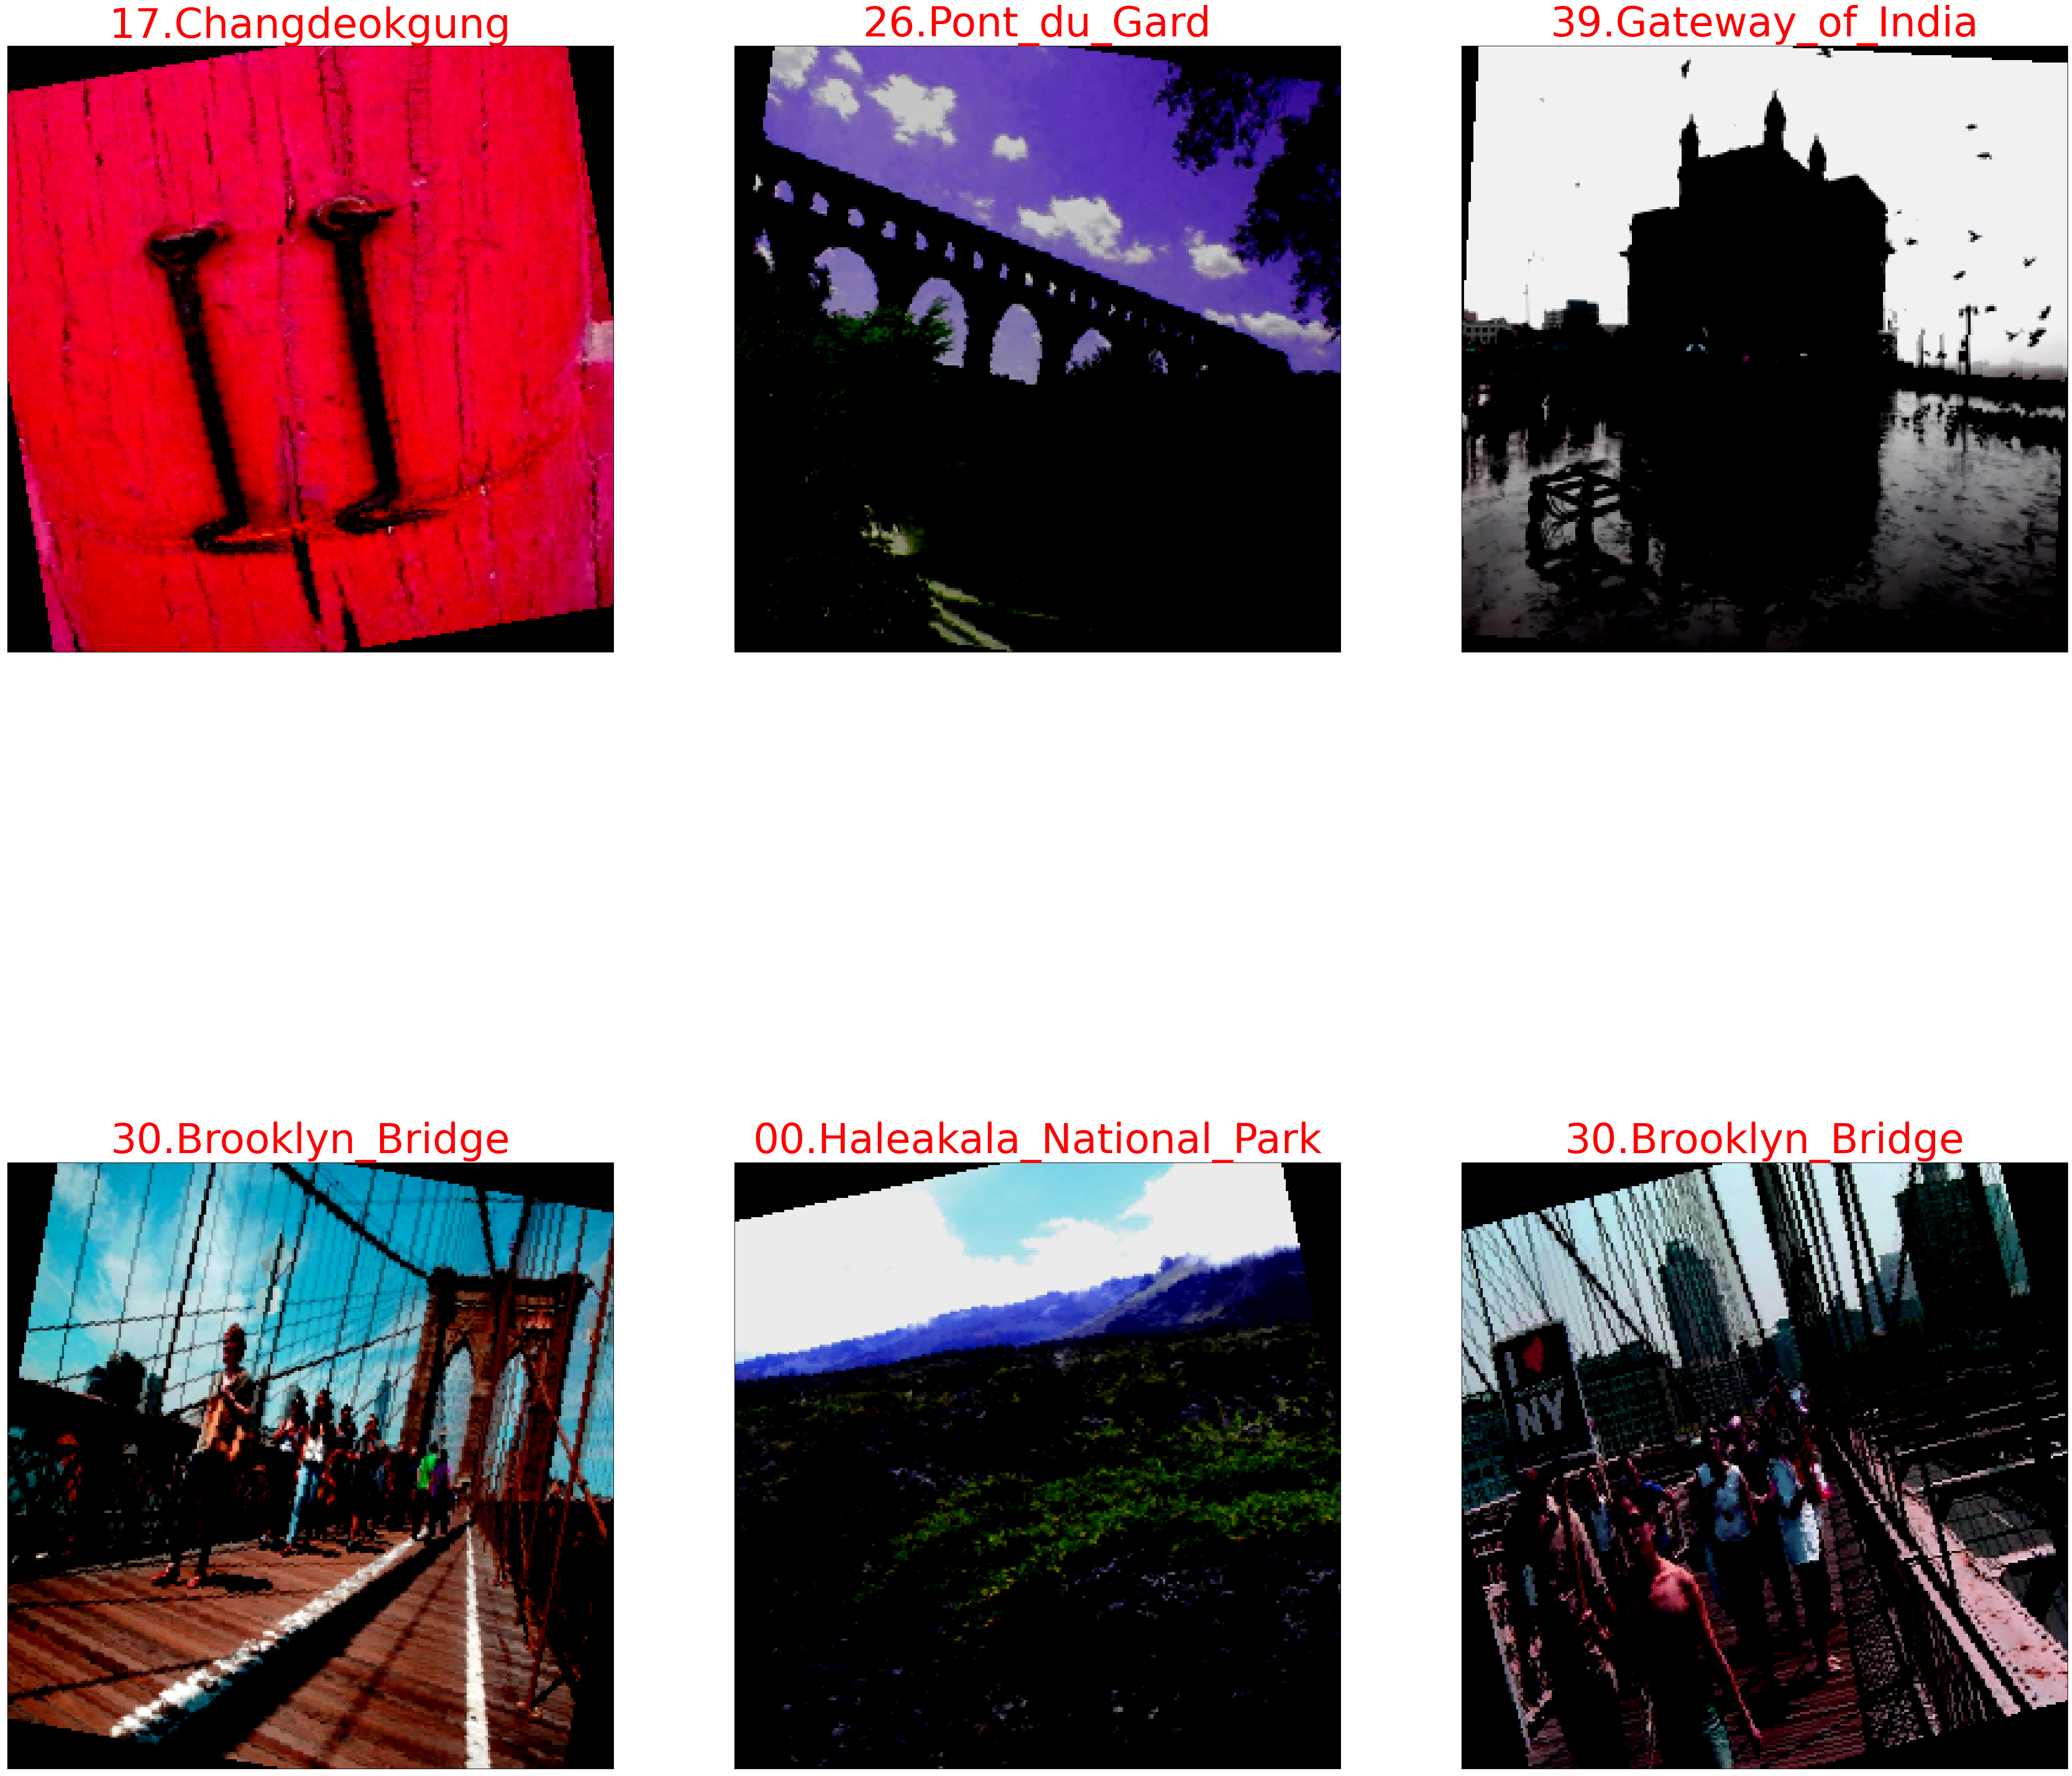

In [13]:
num_images = 6
num_columns = 3
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(54, 54)) # Canvas size of the figure
for idx in np.arange(num_images):
    ax = fig.add_subplot(
            int(np.floor(num_images/num_columns)), # number of rows
            num_columns, 
            idx+1, 
            xticks=[], 
            yticks=[]
        )
    img = train_images[idx]
    img = np.transpose(img,(1,2,0)).clip(0,1)
    ax.imshow(img)
    
    # print out the correct label for each image
    ax.set_title(f"{class_labels[train_labels[idx]]}", fontdict={'fontsize' : 60, 'color' : 'red'})
   

### Initialize use_cuda variable

In [14]:
# useful variable that tells us whether we should use the GPU
def check_gpu()->bool:
    train_on_gpu = torch.cuda.is_available()
    if not train_on_gpu:
        print('CUDA is not available.  Training on CPU ...')
        use_cuda = False
    else:
        print('CUDA is available!  Training on GPU ...')
        use_cuda = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return(device, use_cuda)

In [15]:
device, use_cuda = check_gpu()

CUDA is not available.  Training on CPU ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [16]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss(reduction='sum')# Returns the sum of the loss for each batch

def get_optimizer_scratch(model, learning_rate = 0.001):
    # Reference about Adam optimizer: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
    # Pytorch Reference: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
    #learning_rate = 0.001 #This is the default learning_rate for the Adam algoritm anyway
    optimizer = torch.optim.Adam(model.parameters(), learning_rate) # The Computational approach to doing optimization with the set criterion
    return(optimizer)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [17]:
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(
                    self,
                    n_outputs = 50,
                    image_input_size = 32, #Size of final images from feature functions
                    final_depth = 64,
                    num_hidden1_nodes = 64,
                    num_hidden2_nodes = 50, 
                ):
        """Initializing the neural network

        In Pytorch, to define any neural network you have to name and define any layers that have any
        learned weight values. 

        Args:
            n_outputs (int, optional): The number of target labels. Defaults to 50.
        """
        super(Net, self).__init__()

        num_output_nodes = n_outputs
        
        ## Define layers of a CNN
        ## Reference: https://towardsdatascience.com/pytorch-how-and-when-to-use-module-sequential-modulelist-and-moduledict-7a54597b5f17
        self.features = nn.Sequential(
            OrderedDict(
                [   
                    #('printsize_0', PrintSize()),
                    ('conv_layer1',nn.Conv2d(3, 16, 3, padding=1)), #depth is 3, size = (256,256)
                    # Relu activation function?
                    ('relu1', nn.ReLU(True)), # activation function. Makes sure values are in a consistent range, True means do in place
                    #('printsize_1', PrintSize()),
                    ('conv_layer2',nn.Conv2d(16, 32, 3, padding=1)), #depth is 16, size = (256,256), padding=1, means put a border of zeroes, 1 pixel wide around the image. Instead of zeros, I could use the strategy of nearest value.
                    #('printsize_2', PrintSize()),
                    ('maxpooling_layer1',nn.MaxPool2d(2,2)), #size = (128,128)
                    ('relu2', nn.ReLU(True)), # activation function. Makes sure values are in a consistent range
                    #depth = 32, also cut the resultant filtered image in half with stride =2
                    #('printsize_3', PrintSize()),
                    ('conv_layer3',nn.Conv2d(32, 64, 3, padding=1, stride=2)), #depth=64, size=(128,128)
                    #('printsize_4', PrintSize()),
                    ('maxpooling_layer2',nn.MaxPool2d(2,2)), #depth=64, size=(64,64)
                    ('relu3', nn.ReLU(True)), # activation function. Makes sure values are in a consistent range
                    #('printsize_5', PrintSize()),
                    ('flatten_layer', nn.Flatten()),
                    #('printsize_6', PrintSize()),
                ]
            )
        )

        # Normal Neural Network
        
        ## Define Layers for the Linear Neural Network
        ## Need to determine the final size from the convolution
        self.model = nn.Sequential(
            OrderedDict(
                [
                    ('fc1', nn.Linear(image_input_size * image_input_size * final_depth, num_hidden1_nodes)), # fully connected hidden layer 1
                    ('dropout1', nn.Dropout(.2)), # dropout layer to help reduce overfitting
                    ('relu1', nn.ReLU()), # activation function. Makes sure values are in a consistent range
                    ('fc2', nn.Linear(num_hidden1_nodes, num_hidden2_nodes)), # fully connected hidden layer 
                    ('dropout2', nn.Dropout(.2)), # to dropout layer to help reduce overfitting
                    ('relu2',nn.ReLU()), # activation function.  Makes sure values are in a consistent range
                    ('fc3', nn.Linear(num_hidden2_nodes, num_output_nodes)), # output layer
                    #('softmax', nn.Softmax(dim=1)) # class probabilities.  Don't need this because I am using cross-entropies optimization
                ]
            )
        )          

    def forward(self, x):
        ## Define forward behavior 
        #print(f"Foward: x.size() = {x.size()}")  # [64, 3, 256, 256]
        inputs = self.features(x)
        #print(f"inputs.size() = {inputs.size()}") # [6, 64, 1024]
        result = self.model(inputs) # Original
        return result

In [18]:
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda(device)

In [ ]:

#-#-# TESTING ANOTHER METHOD

# instantiate the CNN
#model_scratch = Net().to(device) # move tensors to GPU if CUDA is available

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [19]:
def train(
        n_epochs, 
        loaders, 
        model, 
        optimizer, 
        criterion, 
        save_path:str = None
    )->Net:
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    batch_size = loaders['train'].batch_size
    num_of_batches = len(loaders['train'])
    num_of_images = batch_size * num_of_batches
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train() # Inherited from nn.Module class. set the module to training mode
        for batch_idx, (X, y) in enumerate(loaders['train']):
            if use_cuda:
                X, y = X.to(device), y.to(device)

            optimizer.zero_grad() # clear the gradients of all optimized variables
            output = model(X)  # forward pass: compute predicted outputs of the batch by passing inputs to the model
            loss = criterion(output, y) # calculate the batch loss
            
            train_loss += loss.item()
            loss.backward() # Locating the weights that produce the most error.  Backward propagating the error
            optimizer.step() # perform a single optimization step (parameter update), updating weights

        if train_loss == np.nan:
            raise ValueError("train loss is nan")

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        # For Loop: Sums all the loss across the batch items
        for batch_idx, (X, y) in enumerate(loaders['valid']):
            if use_cuda:
                X, y = X.to(device), y.to(device)
                
            output = model(X) # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(output, y) # calculate the batch loss 
            valid_loss += loss.item() # update average validation loss, running loss
            #valid_loss += v_loss.item()

        if valid_loss == np.nan:
            raise ValueError("valid loss is nan")

        ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            # update training loss

        train_loss = train_loss/num_of_images
        valid_loss = valid_loss/num_of_images
            
        # print training/validation statistics 
        print(f'Epoch: {epoch}/{n_epochs} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            if save_path is not None:
                print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
                torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

Then let's create a distribution and model that uses the **general rule** for weight initialization; using the range $[-y, y]$, where $y=1/\sqrt{n}$ .

And finally, we'll compare the two models.

In [ ]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(n_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, 'ignore.pt')

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [ ]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, 'model_scratch.pt')

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': None, 'valid': None, 'test': None}





### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [ ]:
## TODO: select loss function
criterion_transfer = None


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer

    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
## TODO: Specify model architecture

model_transfer = None




#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'



#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

